# Imports

In [124]:
import pandas as pd

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import neighbors, datasets
from matplotlib.colors import ListedColormap
from sklearn import metrics
from sklearn.metrics import accuracy_score 
import plot_utils
from statistics import mean 

from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Read Data Set

In [125]:
df = pd.read_csv("mergeData_fixed_time.csv")
df = df.drop('total_time', axis=1) 
pd.options.display.max_columns = None
df.head()

,pedId,speed_total_mean,steering_total_mean,brake_total_mean,throttle_total_mean,acceleration_total_mean,speed_total_var,steering_total_var,brake_total_var,throttle_total_var,acceleration_total_var,distancePed,max_speed,PKE,PKE_Steering,speed_react,reaction_time,pedestriansLevel,visibilityLevel,trafficLevel,gender,age,job,LatestDegree,oftenDrive,accidents,yearsDriving,lastDrive(years),speedingTickets,hadCollision
0,1.0,6.978462,0.493644,0.947244,0.813465,-0.000623,13.607109,0.000420,0.021339,0.032907,0.050404,68.920520,11.669766,1.110623,-0.000432,7.754880,1.048791,0,1,0,0,32,0,0,2,0,10,1.0,0,0
1,3.0,7.045599,0.504890,0.875541,0.911211,-0.045255,33.663919,0.000176,0.065360,0.002429,0.068962,69.359540,13.499710,0.084626,0.000000,13.472353,2.106615,0,1,0,0,32,0,0,2,0,10,1.0,0,0
2,15.0,10.263041,0.478319,0.817679,0.595013,-0.017068,76.873997,0.001610,0.105119,0.076302,0.705761,96.885284,25.851397,5.246326,0.000170,25.585112,0.079211,0,1,0,0,32,0,0,2,0,10,1.0,0,1
3,2.0,11.669419,0.500661,0.891913,0.522365,0.008028,47.209285,0.000396,0.055982,0.112551,0.159198,88.011610,20.055070,2.969647,-0.000258,19.412087,1.161592,2,1,0,0,32,0,0,2,0,10,1.0,0,0
4,4.0,12.187044,0.499769,0.861132,0.558120,0.001881,42.031423,0.000430,0.102442,0.079023,0.158822,105.973686,19.697004,4.033468,0.000066,18.461056,1.275896,2,1,0,0,32,0,0,2,0,10,1.0,0,0


In [126]:
df = df[(df.reaction_time>= 0.3) & (df.reaction_time <= 10)]

In [139]:
## Scenario 1 : Low pedestrian   | High Visibility | Low Traffic
## Scenario 2 : High pedestrian   | High Visibility | Low Traffic
## Scenario 3 : Normal pedestrian | Low Visibility | Low Traffic
## Scenario 4 : Normal pedestrian | High Visibility | Low Traffic 
## Scenario 6 : Normal pedestrian | High Visibility | High Traffic 

def scenario(df):
    if (df['pedestriansLevel'] == 0):
        return 1
    if (df['pedestriansLevel'] == 2):
        return 2
    if (df['visibilityLevel'] == 0):
        return 3
    if (df['trafficLevel'] == 1):
        return 6
    if (df['pedestriansLevel'] == 1):
        return 4
    return 0

df['scenario'] = df.apply(scenario, axis=1)
df[df.scenario == 4]

,pedId,speed_total_mean,steering_total_mean,brake_total_mean,throttle_total_mean,acceleration_total_mean,speed_total_var,steering_total_var,brake_total_var,throttle_total_var,acceleration_total_var,distancePed,max_speed,PKE,PKE_Steering,speed_react,reaction_time,pedestriansLevel,visibilityLevel,trafficLevel,gender,age,job,LatestDegree,oftenDrive,accidents,yearsDriving,lastDrive(years),speedingTickets,hadCollision,scenario


### Distribution of cases

In [140]:
num_obs = len(df)
num_true = len(df.loc[df['hadCollision'] == 1])
num_false = len(df.loc[df['hadCollision'] == 0])
print("Number of True cases:  {0} ({1:2.2f}%)".format(num_true, (num_true/num_obs) * 100))
print("Number of False cases: {0} ({1:2.2f}%)".format(num_false, (num_false/num_obs) * 100))

Number of True cases:  32 (6.72%)
Number of False cases: 444 (93.28%)


We have considerably more false cases than true ones.

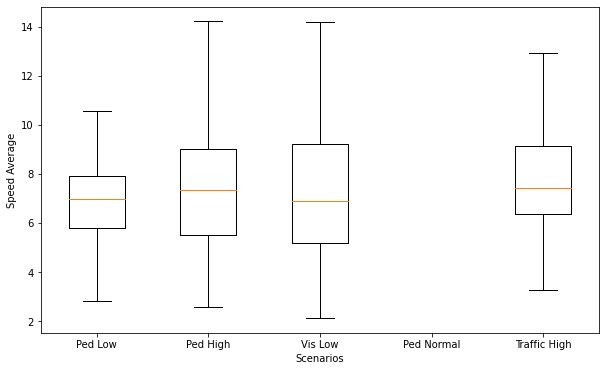

In [141]:
labels = ["Ped Low","Ped High","Vis Low","Ped Normal","Traffic High"]
scenarios = [1,2,3,4,6]

datos = []
for scenario in scenarios:
    datos.append(df[df.scenario == scenario]['speed_total_mean'])


plt.figure(figsize=(10, 6))
plt.boxplot(datos,0, '')
plt.ylabel("Speed Average")
plt.xlabel("Scenarios")
plt.xticks([1,2,3,4,5], labels)
plt.show()

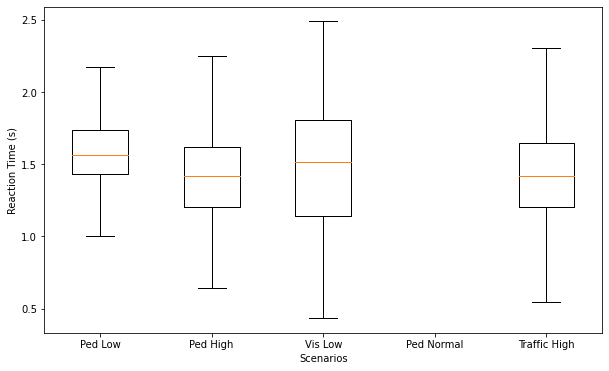

In [142]:
labels = ["Ped Low","Ped High","Vis Low","Ped Normal","Traffic High"]
scenarios = [1,2,3,4,6]

datos = []
for scenario in scenarios:
    datos.append(df[df.scenario == scenario]['reaction_time'])


plt.figure(figsize=(10, 6))
plt.boxplot(datos,0, '')
plt.ylabel("Reaction Time (s)")
plt.xlabel("Scenarios")
plt.xticks([1,2,3,4,5], labels)
#plt.savefig('speedAverageScenariosBoxPlot.pdf')
plt.show()

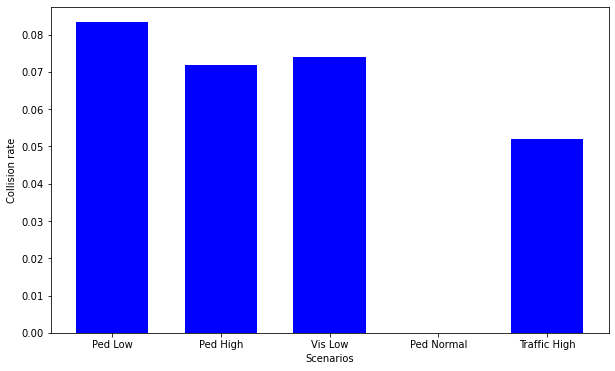

In [143]:
labels = ["Ped Low","Ped High","Vis Low","Ped Normal","Traffic High"]
scenarios = [1,2,3,4,6]

datos = []
for scenario in scenarios:
    datos.append(df[df.scenario == scenario]['hadCollision'].mean())



plt.figure(figsize=(10, 6))
plt.bar(labels, datos,1/1.5,color='blue')
plt.ylabel("Collision rate")
plt.xlabel("Scenarios")

plt.show()

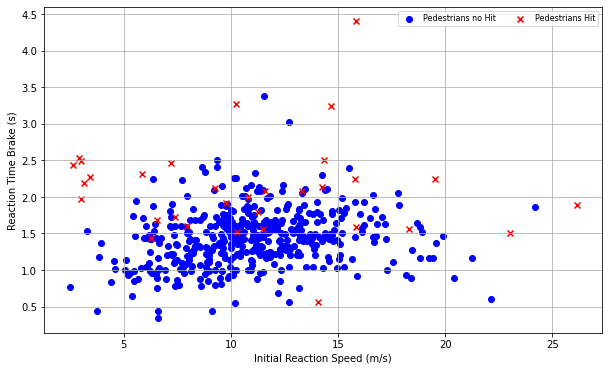

In [144]:
plt.figure(figsize=(10, 6))
plt.xlabel("Initial Reaction Speed (m/s)")
plt.ylabel("Reaction Time Brake (s)")
reactionPressBrake = df[df.reaction_time > 0.15]
reactionPressBrakeNoHits = reactionPressBrake[reactionPressBrake.hadCollision == 0]
reactionPressBrakeHits = reactionPressBrake[reactionPressBrake.hadCollision == 1]


noHits = plt.scatter(reactionPressBrakeNoHits['speed_react'], reactionPressBrakeNoHits['reaction_time'], marker='o', c='b')
hits = plt.scatter(reactionPressBrakeHits['speed_react'], reactionPressBrakeHits['reaction_time'], marker='x', c='r')

plt.legend(( noHits,  hits),
           ("Pedestrians no Hit", "Pedestrians Hit"),
           scatterpoints=1,
           ncol=2,
           fontsize=8)

plt.grid(True)

plt.show()

KeyError: 'distancePed_react'

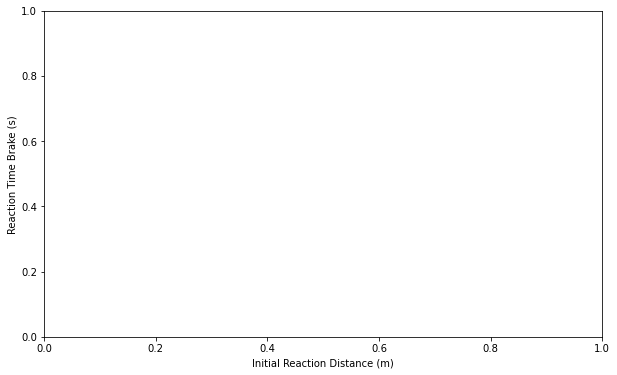

In [145]:
plt.figure(figsize=(10, 6))
plt.xlabel("Initial Reaction Distance (m)")
plt.ylabel("Reaction Time Brake (s)")
reactionPressBrake = df[df.reaction_time > 0.15]
reactionPressBrakeNoHits = reactionPressBrake[reactionPressBrake.hadCollision == 0]
reactionPressBrakeHits = reactionPressBrake[reactionPressBrake.hadCollision == 1]


noHits = plt.scatter(reactionPressBrakeNoHits['distancePed_react'], reactionPressBrakeNoHits['reaction_time'], marker='o', c='b')
hits = plt.scatter(reactionPressBrakeHits['distancePed_react'], reactionPressBrakeHits['reaction_time'], marker='x', c='r')

plt.legend(( noHits,  hits),
           ("Pedestrians no Hit", "Pedestrians Hit"),
           scatterpoints=1,
           ncol=2,
           fontsize=8)

plt.grid(True)

plt.show()

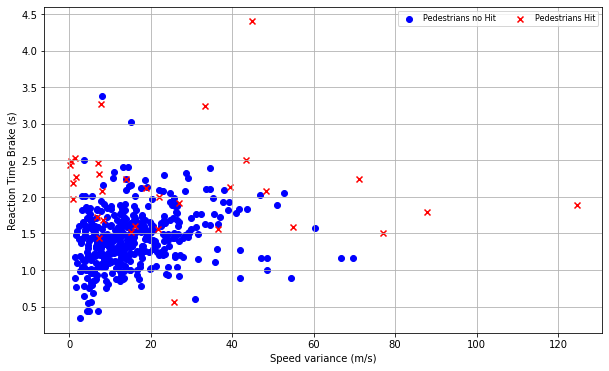

In [146]:
plt.figure(figsize=(10, 6))
plt.xlabel("Speed variance (m/s)")
plt.ylabel("Reaction Time Brake (s)")
reactionPressBrake = df[df.reaction_time > 0.15]
reactionPressBrakeNoHits = reactionPressBrake[reactionPressBrake.hadCollision == 0]
reactionPressBrakeHits = reactionPressBrake[reactionPressBrake.hadCollision == 1]


noHits = plt.scatter(reactionPressBrakeNoHits['speed_total_var'], reactionPressBrakeNoHits['reaction_time'], marker='o', c='b')
hits = plt.scatter(reactionPressBrakeHits['speed_total_var'], reactionPressBrakeHits['reaction_time'], marker='x', c='r')

plt.legend(( noHits,  hits),
           ("Pedestrians no Hit", "Pedestrians Hit"),
           scatterpoints=1,
           ncol=2,
           fontsize=8)

plt.grid(True)

plt.show()

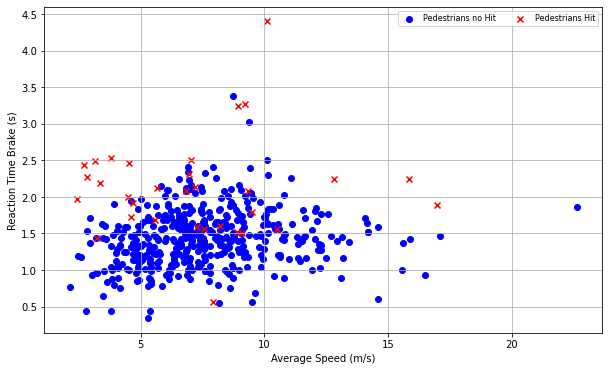

In [160]:
plt.figure(figsize=(10, 6))
plt.xlabel("Average Speed (m/s)")
plt.ylabel("Reaction Time Brake (s)")
reactionPressBrake = df[df.reaction_time > 0.15]
reactionPressBrakeNoHits = reactionPressBrake[reactionPressBrake.hadCollision == 0]
reactionPressBrakeHits = reactionPressBrake[reactionPressBrake.hadCollision == 1]


noHits = plt.scatter(reactionPressBrakeNoHits['speed_total_mean'], reactionPressBrakeNoHits['reaction_time'], marker='o', c='b')
hits = plt.scatter(reactionPressBrakeHits['speed_total_mean'], reactionPressBrakeHits['reaction_time'], marker='x', c='r')

plt.legend(( noHits,  hits),
           ("Pedestrians no Hit", "Pedestrians Hit"),
           scatterpoints=1,
           ncol=2,
           fontsize=8)

plt.grid(True)

plt.show()

In [148]:
pd.unique(df['age'])

array([32, 30, 37, 24, 23, 38, 39, 46, 22, 29, 28, 36, 19, 27, 25])

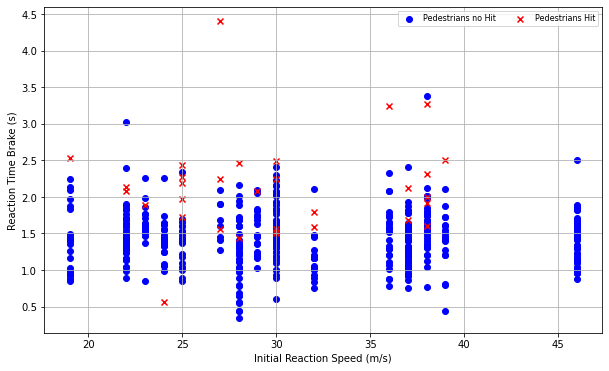

In [149]:
plt.figure(figsize=(10, 6))
plt.xlabel("Initial Reaction Speed (m/s)")
plt.ylabel("Reaction Time Brake (s)")
reactionPressBrake = df[df.reaction_time > 0.15]
reactionPressBrakeNoHits = reactionPressBrake[reactionPressBrake.hadCollision == 0]
reactionPressBrakeHits = reactionPressBrake[reactionPressBrake.hadCollision == 1]


noHits = plt.scatter(reactionPressBrakeNoHits['age'], reactionPressBrakeNoHits['reaction_time'], marker='o', c='b')
hits = plt.scatter(reactionPressBrakeHits['age'], reactionPressBrakeHits['reaction_time'], marker='x', c='r')

plt.legend(( noHits,  hits),
           ("Pedestrians no Hit", "Pedestrians Hit"),
           scatterpoints=1,
           ncol=2,
           fontsize=8)

plt.grid(True)

plt.show()

In [150]:
pd.cut(df.age, 4)

0      (25.75, 32.5]
1      (25.75, 32.5]
3      (25.75, 32.5]
4      (25.75, 32.5]
5      (25.75, 32.5]
           ...      
482    (25.75, 32.5]
483    (25.75, 32.5]
484    (25.75, 32.5]
485    (25.75, 32.5]
486    (25.75, 32.5]
Name: age, Length: 476, dtype: category
Categories (4, interval[float64]): [(18.973, 25.75] < (25.75, 32.5] < (32.5, 39.25] < (39.25, 46.0]]

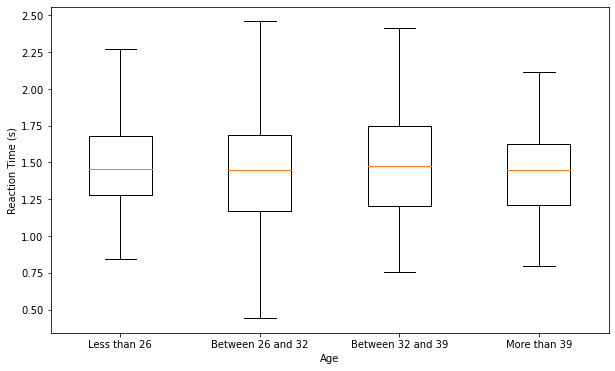

In [151]:
labels = ["Less than 26","Between 26 and 32", "Between 32 and 39","More than 39"]

datos = []
datos.append(df[df.age < 26]['reaction_time'])
datos.append(df[(df.age >= 26) & (df.age <= 32)]['reaction_time'])
datos.append(df[(df.age > 32) & (df.age < 39)]['reaction_time'])
datos.append(df[df.age >= 39]['reaction_time'])



plt.figure(figsize=(10, 6))
plt.boxplot(datos,0, '')
plt.ylabel("Reaction Time (s)")
plt.xlabel("Age")
plt.xticks([1,2,3,4], labels)
#plt.savefig('speedAverageScenariosBoxPlot.pdf')
plt.show()

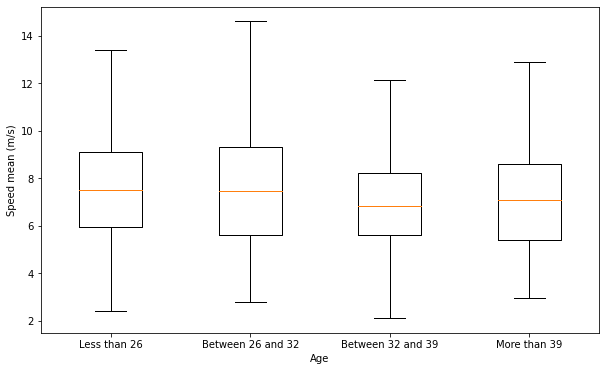

In [152]:
labels = ["Less than 26","Between 26 and 32", "Between 32 and 39","More than 39"]

datos = []
datos.append(df[df.age < 26]['speed_total_mean'])
datos.append(df[(df.age >= 26) & (df.age <= 32)]['speed_total_mean'])
datos.append(df[(df.age > 32) & (df.age < 39)]['speed_total_mean'])
datos.append(df[df.age >= 39]['speed_total_mean'])


plt.figure(figsize=(10, 6))
plt.boxplot(datos,0, '')
plt.ylabel("Speed mean (m/s)")
plt.xlabel("Age")
plt.xticks([1,2,3,4], labels)
plt.show()

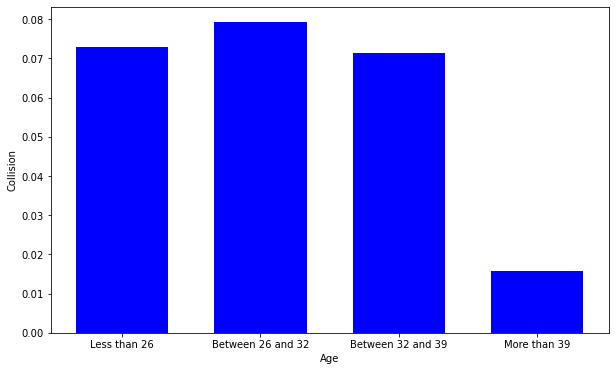

In [153]:
datos = []
datos.append(df[df.age < 26]['hadCollision'].mean())
datos.append(df[(df.age >= 26) & (df.age <= 32)]['hadCollision'].mean())
datos.append(df[(df.age > 32) & (df.age < 39)]['hadCollision'].mean())
datos.append(df[df.age >= 39]['hadCollision'].mean())

plt.figure(figsize=(10, 6))
plt.bar(labels, datos,1/1.5,color='blue')
plt.ylabel("Collision")
plt.xlabel("Age")

plt.show()

In [154]:
pd.unique(df['yearsDriving'])

array([10, 18,  6,  4, 12, 21, 29, 19, 11, 20, 17,  1,  5, 28,  9])

In [155]:
pd.cut(df.yearsDriving, 4)

0      (8.0, 15.0]
1      (8.0, 15.0]
3      (8.0, 15.0]
4      (8.0, 15.0]
5      (8.0, 15.0]
          ...     
482    (8.0, 15.0]
483    (8.0, 15.0]
484    (8.0, 15.0]
485    (8.0, 15.0]
486    (8.0, 15.0]
Name: yearsDriving, Length: 476, dtype: category
Categories (4, interval[float64]): [(0.972, 8.0] < (8.0, 15.0] < (15.0, 22.0] < (22.0, 29.0]]

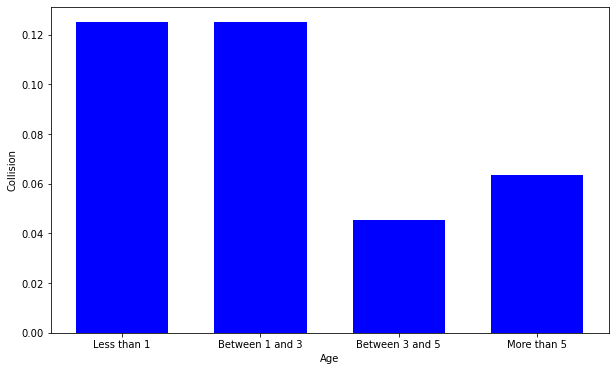

In [156]:
labels = ["Less than 1","Between 1 and 3","Between 3 and 5","More than 5"]

datos = []
datos.append(df[df.yearsDriving <= 1]['hadCollision'].mean())
datos.append(df[(df.yearsDriving >= 1) & (df.yearsDriving < 3)]['hadCollision'].mean())
datos.append(df[(df.yearsDriving >= 3) & (df.yearsDriving < 5)]['hadCollision'].mean())
datos.append(df[df.yearsDriving >= 5]['hadCollision'].mean())



plt.figure(figsize=(10, 6))
plt.bar(labels, datos,1/1.5,color='blue')
plt.ylabel("Collision")
plt.xlabel("Age")

plt.show()

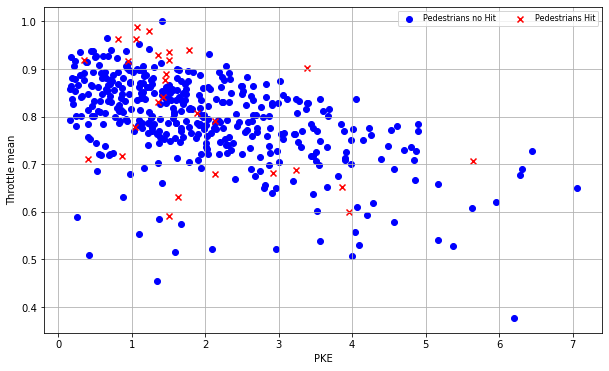

In [164]:
plt.figure(figsize=(10, 6))
plt.xlabel("PKE")
plt.ylabel("Throttle mean")
reactionPressBrake = df[df.PKE > 0.15]
reactionPressBrakeNoHits = reactionPressBrake[reactionPressBrake.hadCollision == 0]
reactionPressBrakeHits = reactionPressBrake[reactionPressBrake.hadCollision == 1]


noHits = plt.scatter(reactionPressBrakeNoHits['PKE'], reactionPressBrakeNoHits['throttle_total_mean'], marker='o', c='b')
hits = plt.scatter(reactionPressBrakeHits['PKE'], reactionPressBrakeHits['throttle_total_mean'], marker='x', c='r')

plt.legend(( noHits,  hits),
           ("Pedestrians no Hit", "Pedestrians Hit"),
           scatterpoints=1,
           ncol=2,
           fontsize=8)

plt.grid(True)

plt.show()

ZeroDivisionError: division by zero

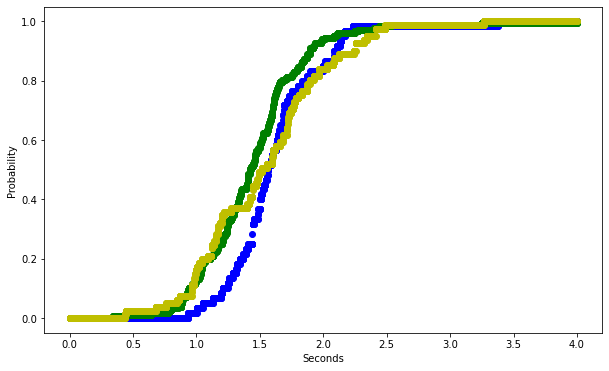

In [162]:
def distProb(x):
    total = len(reactions)
    cant = 0
    for elem in reactions:
        if (x >= elem):
            cant += 1
    prob = cant/total
    return prob

x = np.arange(0, 4, 0.001)
f = np.vectorize(distProb, otypes=[np.float])

plt.figure(figsize=(10, 6))
plt.ylabel("Probability")
plt.xlabel("Seconds")

labels = ["Ped Low","Ped High","Vis Low","Ped Normal","Traffic High"]
scenarios = [1,2,3,4,6]
colors = ['b', 'g', 'y', 'm', 'r']

plots = []
for scenario, color in zip(scenarios, colors):
    reactions = df[df.scenario == scenario]['reaction_time']
    distrib = f(x)
    plots.append(plt.scatter(x, distrib, marker='o', color=color))


plt.legend(plots,
           labels,
           scatterpoints=1,
           ncol=3,
           fontsize=8)
 
plt.grid(True)

plt.show()

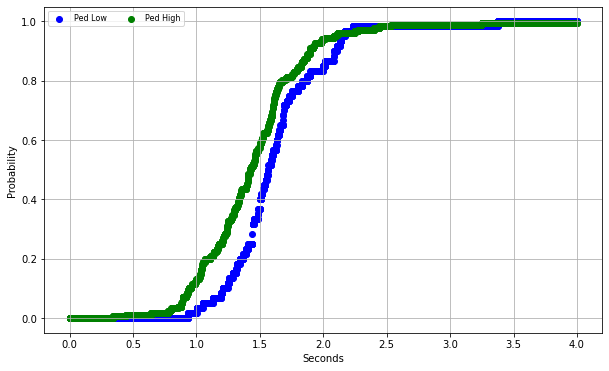

In [161]:
x = np.arange(0, 4, 0.001)
f = np.vectorize(distProb, otypes=[np.float])

plt.figure(figsize=(10, 6))
plt.ylabel("Probability")
plt.xlabel("Seconds")

labels = ["Ped Low","Ped High"]
scenarios = [1,2]
colors = ['b', 'g', 'y', 'm', 'r']

plots = []
for scenario, color in zip(scenarios, colors):
    reactions = df[df.scenario == scenario]['reaction_time']
    distrib = f(x)
    plots.append(plt.scatter(x, distrib, marker='o', color=color))


plt.legend(plots,
           labels,
           scatterpoints=1,
           ncol=3,
           fontsize=8)
 
plt.grid(True)

plt.show()